## A5 Machine Learning: Clustering

contents.

- Importing libraries and data and renaming columns
- preparing the data
- Standardizing the data
- The elbow technique
- the Silhouette Score
- k-means clustering
- comparing the clusters
- conclusions and next steps

## Importing libraries and data and renaming columns

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [2]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# activating all columns to be seen:
pd.set_option('display.max_columns', 100)

In [4]:
# activating all rows to be seen:
pd.set_option('display.max_rows', None)

In [5]:
path = r'C:\Users\chris\Documents\airbnb_Berlin'
listings = pd.read_csv(os.path.join(path,'02 data', 'prepared data', 'listings_details_wrangled.csv'),index_col=False)

In [6]:
listings.shape

(12454, 26)

In [7]:
listings.head(2)

,id,scrape_id,last_scraped,source,host_id,host_name,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,country_region,Price category
0,3176,20230622195229,2023-06-23,previous scrape,3718,Britta,"Coledale, Australia",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,4,83.0,63,184,148,4.63,1,0.87,"Coledale, Australia",Coledale,Australia,Australia,Middle price
1,9991,20230622195229,2023-06-23,city scrape,33852,Philipp,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,180.0,6,14,8,5.00,1,0.08,"Berlin, Germany",Berlin,Germany,Germany,High price


In [8]:
listings.columns

Index(['id', 'scrape_id', 'last_scraped', 'source', 'host_id', 'host_name',
       'host_location', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count', 'reviews_per_month',
       'host_location_cleansed', 'city', 'country', 'country_region',
       'Price category'],
      dtype='object')

## Preparing the data for clustering: no strings, no n/a, no unusual big ranges

### changing 'room-type' into nummerical data.

From the previous analysis, we know that room_type most likely affects the correlation between accommodates and prices. BEfore we delete all non-numerical columns, we make sure we keep this one.

In [9]:
listings['room_type'].value_counts(dropna=False)

Entire home/apt    8138
Private room       4020
Shared room         162
Hotel room          134
Name: room_type, dtype: int64

In [10]:
# Mapping strings with interers 
room_type_mapping = {
    'Entire home/apt': 1,
    'Private room': 2,
    'Shared room': 3,
    'Hotel room': 4
}

In [11]:
#  map()-Function, to update the 'room_type' column
listings['room_type'] = listings['room_type'].map(room_type_mapping)

In [12]:
# checking...FINE! 
listings['room_type'].value_counts(dropna=False)

1    8138
2    4020
3     162
4     134
Name: room_type, dtype: int64

### deleting all non-numerical data

In [13]:
# creating a sub 'df' with only numerical data:
df_orig = listings.select_dtypes(include=['int', 'float'])

In [14]:
df_orig.head() # checking - no strings!

,id,scrape_id,host_id,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month
0,3176,20230622195229,3718,52.53471,13.41810,1,4,83.0,63,184,148,4.63,1,0.87
1,9991,20230622195229,33852,52.53269,13.41805,1,7,180.0,6,14,8,5.00,1,0.08
2,14325,20230622195229,55531,52.54813,13.40366,1,1,70.0,93,1125,26,4.67,4,0.16
3,16644,20230622195229,64696,52.50312,13.43508,1,5,92.0,93,365,48,4.72,2,0.30
4,17904,20230622195229,68997,52.49419,13.42166,1,2,25.0,92,365,299,4.77,1,1.84


### checking for missing values

In [15]:
# checking for any missing values # need to do smth about the reviews_per_month
df_orig.isnull().sum()

id                                   0
scrape_id                            0
host_id                              0
latitude                             0
longitude                            0
room_type                            0
accommodates                         0
price                                0
minimum_nights                       0
maximum_nights                       0
number_of_reviews                    0
review_scores_rating              2367
calculated_host_listings_count       0
reviews_per_month                 2367
dtype: int64

#### ok from previous data cleanings I know, that the numberous listings without a review are listiungs, that just not have been reviewed yet. 

In [16]:
columns_to_drop = [
    'id', # deleting 'id' as well, as it has no real value for clustering
    'scrape_id', # deleting 'id' as well, as it has no real value for clustering
    'host_id', # deleting 'id' as well, as it has no real value for clustering
    'latitude', # deleting as well, as it has no real value for clustering
    'longitude',  # deleting as well, as it has no real value for clustering
    'reviews_per_month'
]

In [17]:
df_orig.drop(columns=columns_to_drop, inplace=True)

In [18]:
# the review_scores_rating we are going to impute. They might be interesting.
mean_review_scores_rating = df_orig['review_scores_rating'].mean()

In [19]:
# fill in the data:
df_orig['review_scores_rating'].fillna(mean_review_scores_rating, inplace=True)

In [20]:
#checking - now it's fine!
df_orig.isnull().sum()

room_type                         0
accommodates                      0
price                             0
minimum_nights                    0
maximum_nights                    0
number_of_reviews                 0
review_scores_rating              0
calculated_host_listings_count    0
dtype: int64

### checking stats...are there any "too big" differences or leftover outliers?

In [21]:
df_orig.describe()

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count
count,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000
mean,1.381082,2.956801,112.874819,43.813875,667.187651,36.601012,4.680443,7.156897
std,0.571365,1.884924,121.646464,47.523391,497.172614,78.605044,0.555565,22.391474
min,1.000000,1.000000,8.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,50.000000,2.000000,130.500000,1.000000,4.680000,1.000000
50%,1.000000,2.000000,81.000000,7.000000,1124.000000,7.000000,4.750000,1.000000
75%,2.000000,4.000000,140.000000,92.000000,1125.000000,33.750000,4.960000,3.000000
max,4.000000,16.000000,3434.000000,365.000000,9999.000000,2074.000000,5.000000,172.000000


ok we'll do something about max nights and have another look at the price.

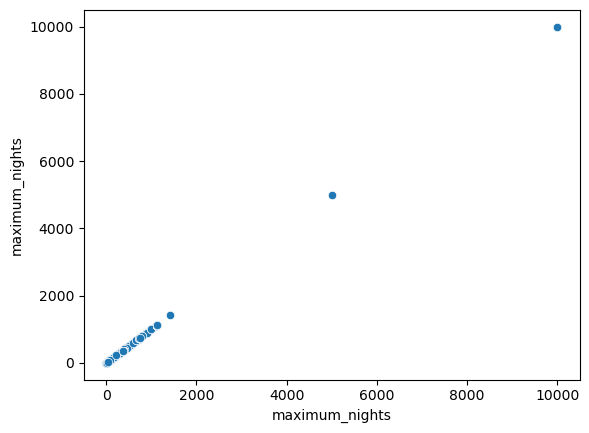

In [22]:
# checking the distribution

scatplot1=sns.scatterplot(x = 'maximum_nights', y = 'maximum_nights',data = df_orig)

In [23]:
# delete all observations > 2000
df_orig = df_orig[df_orig['maximum_nights'] <= 2000]

In [24]:
df_orig.describe()

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count
count,12451.000000,12451.000000,12451.000000,12451.000000,12451.000000,12451.000000,12451.000000,12451.000000
mean,1.381174,2.956550,112.866356,43.823709,665.340696,36.553128,4.680429,7.158140
std,0.571403,1.884911,121.657391,47.524893,481.393471,78.538742,0.555630,22.394028
min,1.000000,1.000000,8.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,50.000000,2.000000,130.000000,1.000000,4.680000,1.000000
50%,1.000000,2.000000,81.000000,7.000000,1124.000000,7.000000,4.750000,1.000000
75%,2.000000,4.000000,140.000000,92.000000,1125.000000,33.000000,4.960000,3.000000
max,4.000000,16.000000,3434.000000,365.000000,1414.000000,2074.000000,5.000000,172.000000


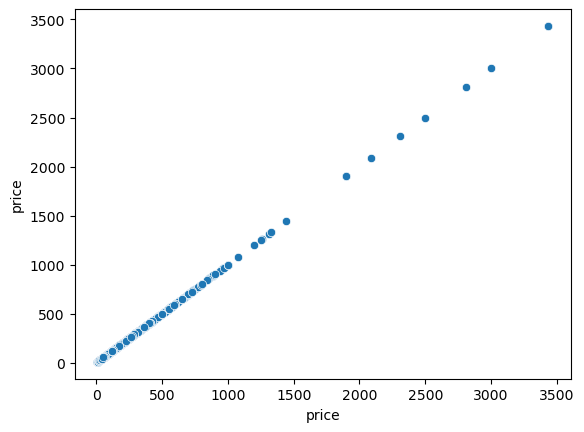

In [25]:
# checking the distribution for 'price'

scatplot1=sns.scatterplot(x = 'price', y = 'price',data = df_orig)

Usually, for a metropole city, there is no limit in prices. But for since the majority of listings are

In [26]:
# counting how many listings are beyong 1000€ a night:
count_price_outlier = (df_orig['price'] >= 1000).sum()

print(f"count_price_outlier: {count_price_outlier}") 

count_price_outlier: 16


In [27]:
# delete the 16 obersvations in 'price' > 1000
df_orig = df_orig[df_orig['price'] < 1000]

In [28]:
df_orig.describe()

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count
count,12435.000000,12435.000000,12435.000000,12435.000000,12435.000000,12435.000000,12435.000000,12435.000000
mean,1.381182,2.952232,110.418657,43.856132,665.173864,36.564696,4.680238,7.160997
std,0.571226,1.872518,96.726070,47.530035,481.423684,78.553115,0.555942,22.407262
min,1.000000,1.000000,8.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,50.000000,2.000000,130.000000,1.000000,4.680000,1.000000
50%,1.000000,2.000000,81.000000,7.000000,1124.000000,7.000000,4.750000,1.000000
75%,2.000000,4.000000,140.000000,92.000000,1125.000000,33.500000,4.960000,3.000000
max,4.000000,16.000000,999.000000,365.000000,1414.000000,2074.000000,5.000000,172.000000


ok that looks much better!

## 1. Standardizing data: Z-Score

In [29]:
# copying the dataframe:
df = df_orig.copy()

In [30]:
df['room_type']= ( df['room_type'] - df['room_type'].mean() ) / df['room_type'].std()

In [31]:
df['accommodates']= ( df['accommodates'] - df['accommodates'].mean() ) / df['accommodates'].std()

In [32]:
df['price']= ( df['price'] - df['price'].mean() ) / df['price'].std()

In [33]:
df['minimum_nights']= ( df['minimum_nights'] - df['minimum_nights'].mean() ) / df['minimum_nights'].std()

In [34]:
df['maximum_nights']= ( df['maximum_nights'] - df['maximum_nights'].mean() ) / df['maximum_nights'].std()

In [35]:
df['number_of_reviews']= ( df['number_of_reviews'] - df['number_of_reviews'].mean() ) / df['number_of_reviews'].std()

In [36]:
df['review_scores_rating']= ( df['review_scores_rating'] - df['review_scores_rating'].mean() ) / df['review_scores_rating'].std()

In [37]:
df['calculated_host_listings_count']= ( df['calculated_host_listings_count'] - df['calculated_host_listings_count'].mean() ) / df['calculated_host_listings_count'].std()

In [38]:
df.head()

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count
0,-0.667306,0.559551,-0.283467,0.402774,-0.999481,1.418598,-0.090365,-0.274955
1,-0.667306,2.161671,0.719365,-0.796468,-1.352600,-0.363635,0.575172,-0.274955
2,-0.667306,-1.042570,-0.417867,1.033954,0.955138,-0.134491,-0.018415,-0.141070
3,-0.667306,1.093591,-0.190421,1.033954,-0.623513,0.145574,0.071522,-0.230327
4,-0.667306,-0.508530,-0.883099,1.012915,-0.623513,3.340864,0.161460,-0.274955


## 2 A. The elbow technique: Finding the right number of clusters

In [39]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [40]:
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

score

C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\clust

[-99472.000000001,
 -81531.87710383961,
 -71813.5702664348,
 -62663.53263962621,
 -54340.67362762091,
 -48100.19217600056,
 -42102.33570908139,
 -37875.59604570432,
 -34540.946458240454]

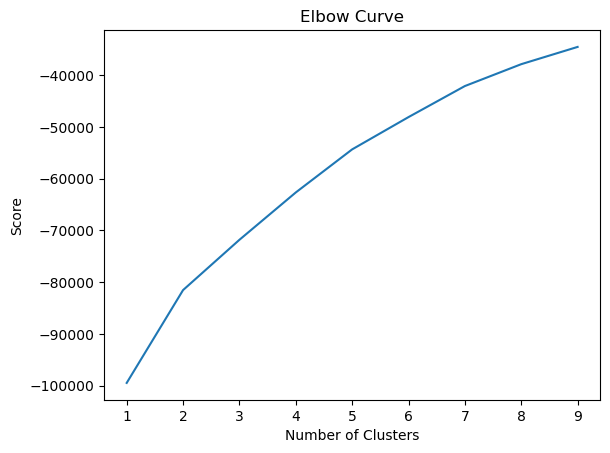

In [41]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

#####  That's of no use at all. We need a better approach!

## 2 B. The Silhouette Method: Finding the right number of clusters

In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

max_clusters = 10  # I took randomly 10 as the max number of clusters

silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(df)  

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\sklearn\clust

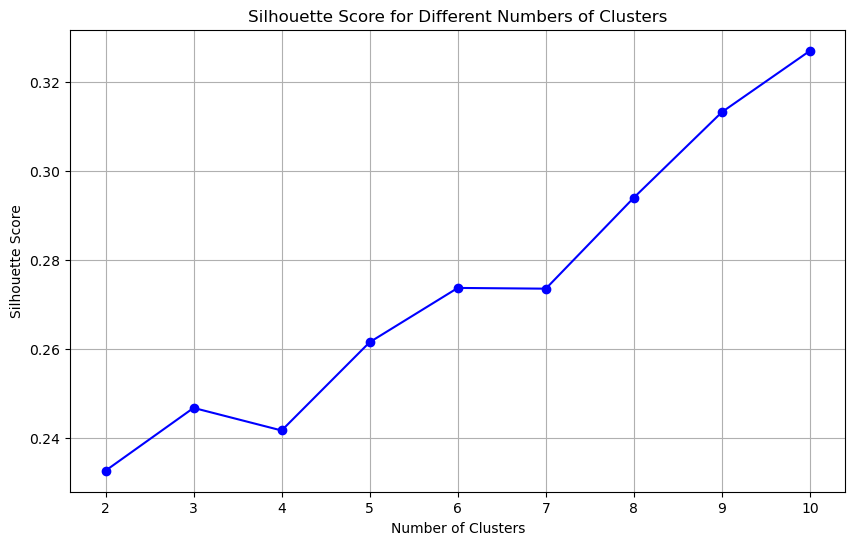

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

##### About the Silhouette Coefficient in general
- the Silhouette Coefficient can range between -1 and 1. 
- it measures the quality of clustering. 
- The silhouette score provides a quantitative measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 
- Close to 1: This is what we want: A high Silhouette score indicates that data points are well separated within their clusters, indicating good clustering.
- Close to 0: A Silhouette score close to 0 suggests that data points are near the boundary between clusters or that there may be overlaps between clusters.
- Close to -1: A low Silhouette score suggests that data points are likely incorrectly grouped and would fit better in other clusters.
- generally, it's still a matter of choice, how many clusters one takes for the k-means. 10 clusters, as above, would be to much. 

#####  About the graph above:
- First, all scores are above zero, which is very good. 
- The rise from 2 to 3 suggests that adding a third cluster improved the separation of data points.
- The drop  from 3 to 4 indicates that adding another cluster doesn't improve separation.


#### For the k-means, I go for n = 3 clusters.

## 3. k-means clustering: Creating the Clusters

In [44]:
# Create the k-means object.

# kmeans = KMeans(n_clusters = 3, n_jobs = -1) # that code lead to the error: TypeError: KMeans.__init__() got an unexpected keyword argument 'n_jobs'
kmeans = KMeans(n_clusters=3) # without n_jobs it might work

In [45]:
# Fit the k-means object to the data.

kmeans.fit(df)

C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [46]:
df['clusters'] = kmeans.fit_predict(df)

C:\Users\chris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [47]:
df.head(5)

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters
0,-0.667306,0.559551,-0.283467,0.402774,-0.999481,1.418598,-0.090365,-0.274955,1
1,-0.667306,2.161671,0.719365,-0.796468,-1.352600,-0.363635,0.575172,-0.274955,1
2,-0.667306,-1.042570,-0.417867,1.033954,0.955138,-0.134491,-0.018415,-0.141070,0
3,-0.667306,1.093591,-0.190421,1.033954,-0.623513,0.145574,0.071522,-0.230327,0
4,-0.667306,-0.508530,-0.883099,1.012915,-0.623513,3.340864,0.161460,-0.274955,1


In [48]:
df['clusters'].value_counts()

1    6580
0    5683
2     172
Name: clusters, dtype: int64

## 4. Comparing the clusters

In [49]:
# transferring the cluster columns into the 'df_orig' with not-standardized values for better comparison of clusters:

df_orig['clusters'] = df['clusters']

In [50]:
df_orig.head(3)

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters
0,1,4,83.0,63,184,148,4.63,1,1
1,1,7,180.0,6,14,8,5.00,1,1
2,1,1,70.0,93,1125,26,4.67,4,0


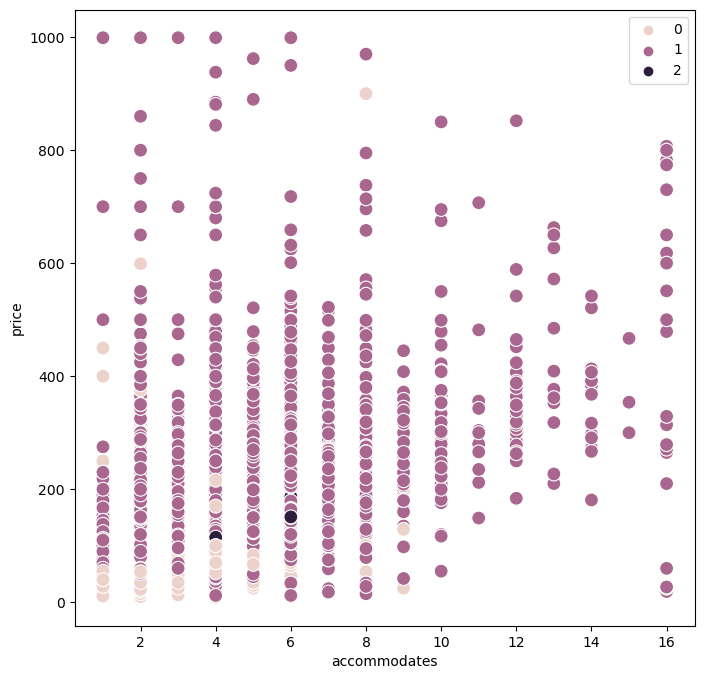

In [51]:
# Plot the clusters for the "price" and "accommodates" variables.

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=df_orig['accommodates'], y=df_orig['price'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('accommodates') # Label x-axis.
plt.ylabel('price') # Label y-axis.
plt.show()

 It's a bit hard to discern the dots, I'll try another one

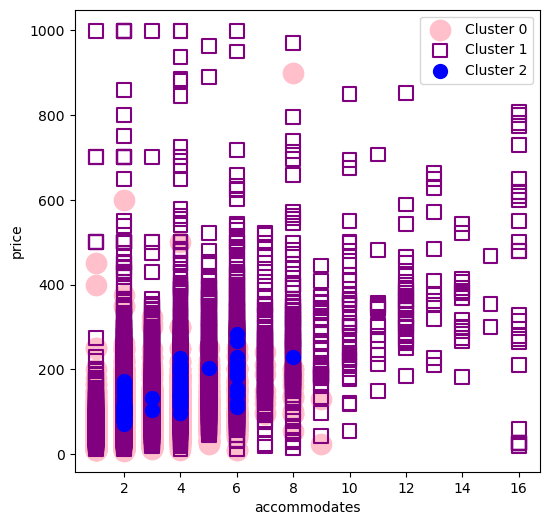

In [52]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'accommodates'],
    df_orig.loc[kmeans.labels_ == 0, 'price'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'accommodates'],
    df_orig.loc[kmeans.labels_ == 1, 'price'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'accommodates'],
    df_orig.loc[kmeans.labels_ == 2, 'price'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('accommodates')
plt.ylabel('price')
plt.legend()
plt.show()

Accommodates and price doesn't help. There is no visible cluster

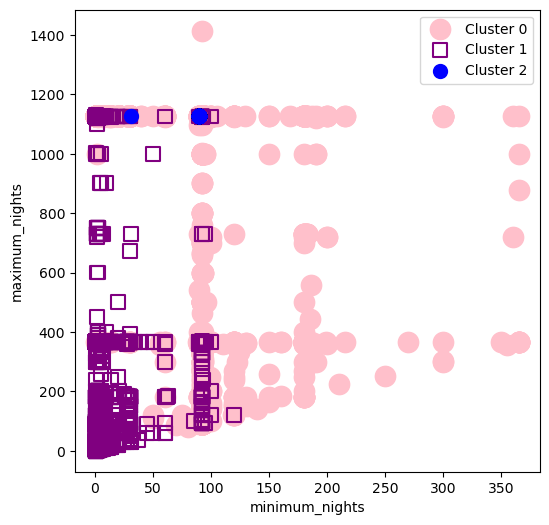

In [53]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 0, 'maximum_nights'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 1, 'maximum_nights'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 2, 'maximum_nights'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('minimum_nights')
plt.ylabel('maximum_nights')
plt.legend()
plt.show()

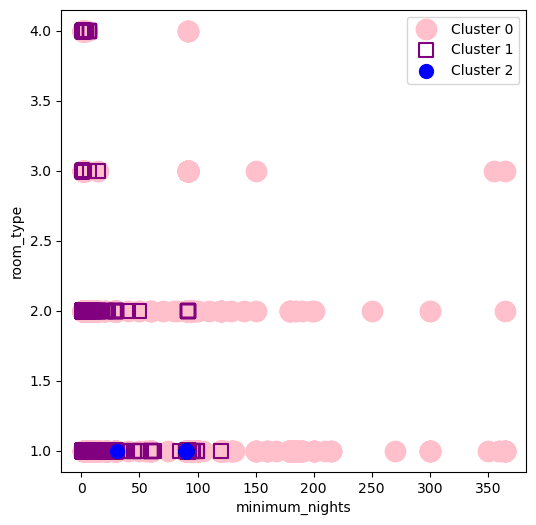

In [54]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 0, 'room_type'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 1, 'room_type'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 2, 'room_type'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('minimum_nights')
plt.ylabel('room_type')
plt.legend()
plt.show()

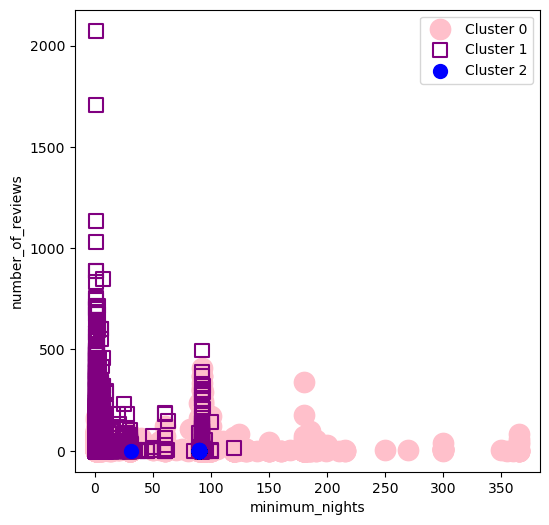

In [55]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 0, 'number_of_reviews'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 1, 'number_of_reviews'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'minimum_nights'],
    df_orig.loc[kmeans.labels_ == 2, 'number_of_reviews'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('minimum_nights')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

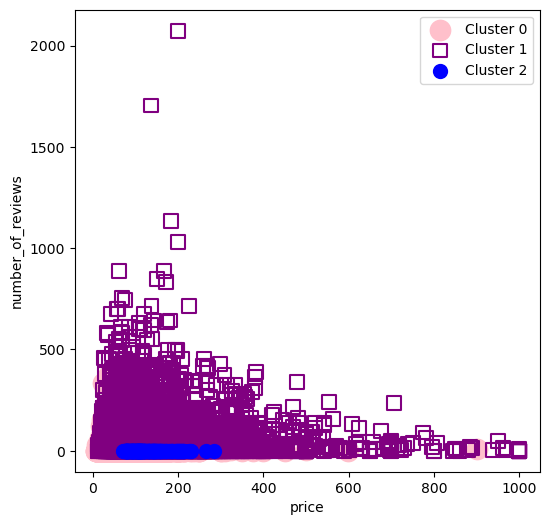

In [56]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'price'],
    df_orig.loc[kmeans.labels_ == 0, 'number_of_reviews'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'price'],
    df_orig.loc[kmeans.labels_ == 1, 'number_of_reviews'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'price'],
    df_orig.loc[kmeans.labels_ == 2, 'number_of_reviews'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('price')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

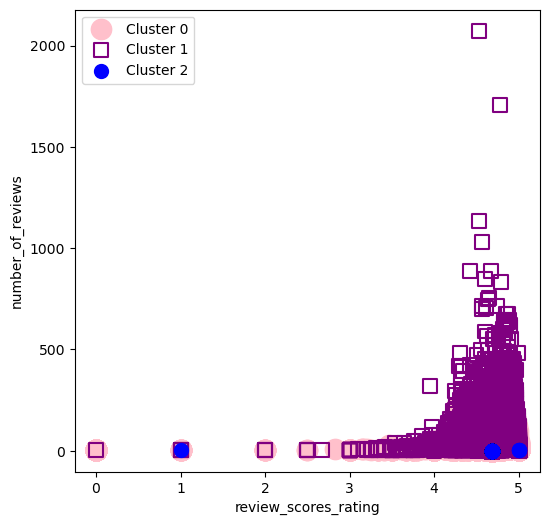

In [57]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'review_scores_rating'],
    df_orig.loc[kmeans.labels_ == 0, 'number_of_reviews'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'review_scores_rating'],
    df_orig.loc[kmeans.labels_ == 1, 'number_of_reviews'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'review_scores_rating'],
    df_orig.loc[kmeans.labels_ == 2, 'number_of_reviews'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('review_scores_rating')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

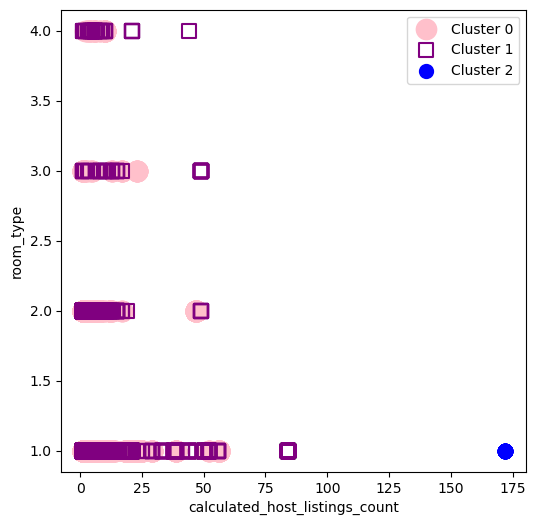

In [58]:
# Create an amptey plot
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plots dots cluster = 0:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 0, 'calculated_host_listings_count'],
    df_orig.loc[kmeans.labels_ == 0, 'room_type'],
    color='pink',
    label='Cluster 0',
    s=200,
    marker='o',
    facecolors='pink',  # Füllen Sie den Punkt mit blau
    edgecolors='pink',  # Randfarbe für den Punkt in blau
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 1:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 1, 'calculated_host_listings_count'],
    df_orig.loc[kmeans.labels_ == 1, 'room_type'],
    color='purple',  # Die Farbe ist pink
    label='Cluster 1',
    s=100,
    marker='s',
    facecolors='none',  # Keine Füllung für den Punkt
    edgecolors='purple',  # Randfarbe für den Punkt in pink
    linewidth=1.5  # Breite der Randlinie
)

# Plots dots cluster = 2:
ax.scatter(
    df_orig.loc[kmeans.labels_ == 2, 'calculated_host_listings_count'],
    df_orig.loc[kmeans.labels_ == 2, 'room_type'],
    color='blue',
    label='Cluster 2',
    s=90,
    marker='o',
    facecolors='blue',  # Füllen Sie den Punkt mit lila
    edgecolors='blue',  # Randfarbe für den Punkt in lila
    linewidth=1.5  # Breite der Randlinie
)

ax.grid(False)  # Gitter entfernen
plt.xlabel('calculated_host_listings_count')
plt.ylabel('room_type')
plt.legend()
plt.show()

## Aggregating the cluster comparison

In [59]:
df_orig.loc[df_orig['clusters'] == 0, 'cluster'] = 'pink'
df_orig.loc[df_orig['clusters'] == 1, 'cluster'] = 'purple'
df_orig.loc[df_orig['clusters'] == 2, 'cluster'] = 'blue'

In [60]:
# sub for 'blue' Cluster
df_clus_blue = df_orig[df_orig['cluster'] == 'blue']

# sub for 'orange' Cluster
df_clus_pink = df_orig[df_orig['cluster'] == 'pink']

# sub for 'orange' Cluster
df_clus_purple = df_orig[df_orig['cluster'] == 'purple']


### Analyzing the blue cluster: It's only whole apartments (room_type = 1), Hostname = 'Blueground"

In [61]:
df_clus_blue.head()

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters,cluster
9306,1,2,158.0,90,1125,0,4.680443,172,2,blue
9307,1,2,101.0,90,1125,0,4.680443,172,2,blue
9308,1,2,101.0,90,1125,0,4.680443,172,2,blue
9309,1,2,106.0,90,1125,0,4.680443,172,2,blue
9492,1,2,105.0,90,1125,0,4.680443,172,2,blue


In [62]:
df_clus_blue.describe().round(1)

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters
count,172.0,172.0,172.0,172.0,172.0,172.0,172.0,172.0,172.0
mean,1.0,3.0,126.7,89.7,1125.0,0.0,4.7,172.0,2.0
std,0.0,1.4,42.1,4.5,0.0,0.2,0.3,0.0,0.0
min,1.0,2.0,70.0,31.0,1125.0,0.0,1.0,172.0,2.0
25%,1.0,2.0,95.0,90.0,1125.0,0.0,4.7,172.0,2.0
50%,1.0,2.0,114.0,90.0,1125.0,0.0,4.7,172.0,2.0
75%,1.0,4.0,148.0,90.0,1125.0,0.0,4.7,172.0,2.0
max,1.0,8.0,284.0,90.0,1125.0,1.0,5.0,172.0,2.0


In [63]:
df_clus_blue['room_type'].value_counts(dropna=False)

1    172
Name: room_type, dtype: int64

In [64]:
df_clus_pink['room_type'].value_counts(dropna=False)

1    3181
2    2406
3      59
4      37
Name: room_type, dtype: int64

In [65]:
df_clus_purple['room_type'].value_counts(dropna=False)

1    4770
2    1612
3     101
4      97
Name: room_type, dtype: int64

In [66]:
df_clus_blue['minimum_nights'].value_counts(dropna=False)

90    171
31      1
Name: minimum_nights, dtype: int64

In [67]:
df_clus_blue['maximum_nights'].value_counts(dropna=False)

1125    172
Name: maximum_nights, dtype: int64

In [68]:
df_clus_blue['calculated_host_listings_count'].value_counts(dropna=False)

172    172
Name: calculated_host_listings_count, dtype: int64

In [69]:
subset_listingscount = listings.loc[listings['calculated_host_listings_count'] == 172]

In [70]:
subset_listingscount.head(3)

,id,scrape_id,last_scraped,source,host_id,host_name,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,country_region,Price category
9306,54025960,20230622195229,2023-06-23,city scrape,434485440,Blueground,"Berlin, Germany",Kurfürstendamm,Charlottenburg-Wilm.,52.500575,13.329638,Entire rental unit,1,2,158.0,90,1125,0,NaN,172,NaN,"Berlin, Germany",Berlin,Germany,Germany,Middle price
9307,54025990,20230622195229,2023-06-22,city scrape,434485440,Blueground,"Berlin, Germany",Kurfürstendamm,Charlottenburg-Wilm.,52.500575,13.329638,Entire rental unit,1,2,101.0,90,1125,0,NaN,172,NaN,"Berlin, Germany",Berlin,Germany,Germany,Middle price
9308,54026053,20230622195229,2023-06-22,city scrape,434485440,Blueground,"Berlin, Germany",Kurfürstendamm,Charlottenburg-Wilm.,52.500575,13.329638,Entire rental unit,1,2,101.0,90,1125,0,NaN,172,NaN,"Berlin, Germany",Berlin,Germany,Germany,Middle price


In [71]:
subset_listingscount['host_name'].value_counts(dropna=False)

Blueground    172
Name: host_name, dtype: int64

##### The blue cluster seems to be a chain of some sort. A Host named "Blueground" rents whole apartments only, mimimum almost 90 days.

### Comparing the pink and the purple cluster

In [72]:
df_clus_pink.describe().round(1)

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters
count,5683.0,5683.0,5683.0,5683.0,5683.0,5683.0,5683.0,5683.0,5683.0
mean,1.5,2.3,62.3,85.7,955.2,11.9,4.6,2.9,0.0
std,0.6,1.1,41.4,34.9,337.8,27.1,0.7,7.4,0.0
min,1.0,1.0,8.0,1.0,81.0,0.0,0.0,1.0,0.0
25%,1.0,2.0,35.0,92.0,1125.0,0.0,4.7,1.0,0.0
50%,1.0,2.0,52.0,92.0,1125.0,3.0,4.7,1.0,0.0
75%,2.0,3.0,79.0,92.0,1125.0,11.0,5.0,1.0,0.0
max,4.0,9.0,900.0,365.0,1414.0,408.0,5.0,56.0,0.0


In [73]:
df_clus_purple.describe().round(1)

,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,clusters
count,6580.0,6580.0,6580.0,6580.0,6580.0,6580.0,6580.0,6580.0,6580.0
mean,1.3,3.5,151.6,6.6,402.7,58.8,4.7,6.5,1.0
std,0.6,2.2,111.6,16.1,438.6,99.9,0.3,13.3,0.0
min,1.0,1.0,12.0,1.0,1.0,0.0,0.0,1.0,1.0
25%,1.0,2.0,80.0,1.0,30.0,4.0,4.7,1.0,1.0
50%,1.0,3.0,123.0,2.0,365.0,19.0,4.8,1.0,1.0
75%,2.0,4.0,189.0,4.0,750.0,71.0,5.0,6.0,1.0
max,4.0,16.0,999.0,120.0,1130.0,2074.0,5.0,84.0,1.0


#### Aggregating the results from describe()

In [74]:
df_orig.groupby('cluster').agg({'price':['min', 'max','mean'], 
                         'room_type':['min', 'max','mean'],
                         'minimum_nights':['min', 'max','mean'],
                         'maximum_nights':['min', 'max','mean'],
                         'accommodates':['min', 'max','mean'], 
                         'number_of_reviews':['min', 'max','mean'],
                         'calculated_host_listings_count':['min', 'max','mean']})

price                    room_type               minimum_nights       \
          min    max        mean       min max      mean            min  max   
cluster                                                                        
blue     70.0  284.0  126.651163         1   1  1.000000             31   90   
pink      8.0  900.0   62.251452         1   4  1.463664              1  365   
purple   12.0  999.0  151.595289         1   4  1.319909              1  120   

                   maximum_nights                    accommodates      \
              mean            min   max         mean          min max   
cluster                                                                 
blue     89.656977           1125  1125  1125.000000            2   8   
pink     85.652648             81  1414   955.159775            1   9   
purple    6.560182              1  1130   402.699696            1  16   

                  number_of_reviews                   \
             mean               min   max       mean   
cluster                                                
blue     2.970930                 0     1   0.029070   
pink     2.321837                 0   408  11.897061   
purple   3.496201                 0  2074  58.824620   

        calculated_host_listings_count                   
                                   min  max        mean  
cluster                                                  
blue                               172  172  172.000000  
pink                                 1   56    2.945451  
purple                               1   84    6.493009

## 5. Conclusions

##### The visuals where not that helpful, with rather integers than floats, but after building subsetsThe profiling or clustering was more clear:

##### Blue = whole apartments only, Host is always 'Blueground':
- this group stands apart as a cluster, because it's highly homogenic. It looks like a commercial chain of some sort.
- min nights= almost all = 90
- max-nights = all = 1125
- host listings count = 172: hostname is always bluebround. 
- smallest cluster, by far.
- rather little std. deviations = very homogenic

##### Pink = most booked listings, rather for short term stays, 
- mixture of all room-types.
- mostly high std., deviations = very heterogenic group of listings (or hosts)
- avg price = 156 (but high std deviation)
- avg min night = 6,6
- avg number_of_reviews = 58,8 (number of reviews is like the minimum number of how often this listing was booked)

##### Purple = not that often booked (=reviewed), rather longer termed stays:
- mixture of all room-types.
- mostly high std., deviations = very heterogenic group of listings (or hosts)
- avg price = 62 (but high std deviation)
- avg min night = 85,7
- avg number_of_reviews = 11,9

##### Next steps: 
The blue group clearly stands out. Next step will be to analyze this further. A private owner renting 172 whole apartments on airbnb? Is that a hotel chain, that has all the other hotel rooms (ropom_type = 4?). 


## Exporting dataframe with cluster columns listings_details_final.csv

In [75]:
# reverse the room-type back into strings
reverse_room_type_mapping = {
    1: 'Entire home/apt',
    2: 'Private room',
    3: 'Shared room',
    4: 'Hotel room'
}

In [76]:
listings['room_type'] = listings['room_type'].map(reverse_room_type_mapping)

In [77]:
#adding the clusters column to the original dataframe listings
listings['clusters'] = df_orig['clusters']

In [78]:
listings.head()

,id,scrape_id,last_scraped,source,host_id,host_name,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,country_region,Price category,clusters
0,3176,20230622195229,2023-06-23,previous scrape,3718,Britta,"Coledale, Australia",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,4,83.0,63,184,148,4.63,1,0.87,"Coledale, Australia",Coledale,Australia,Australia,Middle price,1.0
1,9991,20230622195229,2023-06-23,city scrape,33852,Philipp,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,180.0,6,14,8,5.00,1,0.08,"Berlin, Germany",Berlin,Germany,Germany,High price,1.0
2,14325,20230622195229,2023-06-23,city scrape,55531,Chris + Oliver,"Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,70.0,93,1125,26,4.67,4,0.16,"Berlin, Germany",Berlin,Germany,Germany,Low price,0.0
3,16644,20230622195229,2023-06-23,city scrape,64696,Rene,"Santa Cruz, CA",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.50312,13.43508,Entire condo,Entire home/apt,5,92.0,93,365,48,4.72,2,0.30,"Santa Cruz, CA",Santa Cruz,country unknown,country unknown,Middle price,0.0
4,17904,20230622195229,2023-06-23,city scrape,68997,Matthias,"Rio de Janeiro, Brazil",Reuterstraße,Neukölln,52.49419,13.42166,Entire rental unit,Entire home/apt,2,25.0,92,365,299,4.77,1,1.84,"Rio de Janeiro, Brazil",Rio de Janeiro,Brazil,South America,Low price,1.0


In [79]:
# exporting the dataframe:
listings.to_csv(os.path.join(path, '02 data', 'prepared data', 'listings_details_final.csv'))

In [80]:
#listings.head()

,id,scrape_id,last_scraped,source,host_id,host_name,host_location,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,host_location_cleansed,city,country,country_region,Price category,clusters
0,3176,20230622195229,2023-06-23,previous scrape,3718,Britta,"Coledale, Australia",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,4,83.0,63,184,148,4.63,1,0.87,"Coledale, Australia",Coledale,Australia,Australia,Middle price,1.0
1,9991,20230622195229,2023-06-23,city scrape,33852,Philipp,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,180.0,6,14,8,5.00,1,0.08,"Berlin, Germany",Berlin,Germany,Germany,High price,1.0
2,14325,20230622195229,2023-06-23,city scrape,55531,Chris + Oliver,"Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,70.0,93,1125,26,4.67,4,0.16,"Berlin, Germany",Berlin,Germany,Germany,Low price,0.0
3,16644,20230622195229,2023-06-23,city scrape,64696,Rene,"Santa Cruz, CA",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.50312,13.43508,Entire condo,Entire home/apt,5,92.0,93,365,48,4.72,2,0.30,"Santa Cruz, CA",Santa Cruz,country unknown,country unknown,Middle price,0.0
4,17904,20230622195229,2023-06-23,city scrape,68997,Matthias,"Rio de Janeiro, Brazil",Reuterstraße,Neukölln,52.49419,13.42166,Entire rental unit,Entire home/apt,2,25.0,92,365,299,4.77,1,1.84,"Rio de Janeiro, Brazil",Rio de Janeiro,Brazil,South America,Low price,1.0


In [81]:
# exporting the dataframe to Excel:
#listings.to_excel(os.path.join(path, '02 data', 'prepared data', 'listings_details_final.xlsx'), index=False)